# 1612615-Đào Việt Thắng

# 1612485-Nguyễn Anh Pha

## Bài toán: Đề xuất giá vé cho nhà tổ chức sự kiện dựa trên thông tin liên quan.

## Đào Việt Thắng - 1612615
## Nguyễn Anh Pha - 1612485

### Bài toán: Dự đoán giá vé sự kiện dành cho các nhà tổ chức sự kiện
#### Dựa vào mô hình nhóm đề xuất các nhà tổ chức sự kiện có thể ước lượng được giá vé ở các địa điểm tổ chức sự kiện. Bài toán lấy ý tưởng từ việc một nhà tổ chức sự kiện muốn tổ chức một sự kiện ở trong khu vực, thời gian nào nào đó thì muốn biết ước lượng giá vé theo yêu cầu đó là bao nhiêu.

### Thu thập dữ liệu:
Dữ liệu được lấy từ trang web: https://ticketbox.vn. Trang web không có file robots.txt
Dữ liệu bao gồm:

    116 dòng và 8 cột ['tên sự kiện', 'giá', 'địa điểm', 'loại sự kiện', 'tháng', 'ngày', 'thời gian', 'địa điểm cụ thể']

Nhóm đề xuất dựa vào các thông tin: ['địa điểm', 'loại sự kiện', 'tháng', 'ngày', 'thời gian'] để dự đoán giá vé.

Vấn đề gặp phải: dữ liệu thu được còn khá ít.

In [2]:
from requests_html import HTMLSession
import requests
import json
import time
import pandas as pd
import datetime as dt
import re
from bs4 import BeautifulSoup
from dateutil.parser import parse
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException, JavascriptException
from selenium.webdriver.common.action_chains import ActionChains

# Import

In [7]:
def crawl(nr_of_events=100, links=["https://ticketbox.vn/events/ho-chi-minh", "https://ticketbox.vn/events/ha-noi"]):
    data = []
    for l in links:
        driver = webdriver.Chrome("./ChromeSetup")
        driver.get(l)
        while True:
            try:
                soup = BeautifulSoup(driver.page_source, "html")
                cards = soup.findAll("div", {"class": "card"})
                if len(cards) >= nr_of_events:
                    driver.close()
                    break
                button = driver.find_element_by_class_name("btn-loadmore")
                WebDriverWait(driver, 3).until(EC.invisibility_of_element_located((By.CLASS_NAME, "loading-screen")))
                ActionChains(driver).move_to_element(button).click(button).perform()
            except JavascriptException:
                driver.close()
                break
        for card in cards:
            title = card.findAll("div", {"class": "event-title"})
            title = title[0].text.strip() if title else ''
            if title == '':
                continue
            link = card.findAll("a", href=True)
            if link:
                r = HTMLSession().get(link[0]['href'])
                tmp = BeautifulSoup(r.html.raw_html, "html")
                try:
                    time = tmp.findAll("div", {"class": "s1"})[0].findAll("div", {"class": "ev-txt"})
                    time = time[0].text.strip() if time else ''
                except:
                    time = ''
                try:
                    location = tmp.findAll("div", {"class": "s2"})[0].findAll("div", {"class": "ev-txt"})
                    location = location[0].text.strip() if location else ''
                except:
                    location = ''
            else:
                time = ''
                location = ''
            price = card.findAll("div", {"class": "event-price"})
            price = price[0].text.strip() if price else ''
            venue = card.findAll("span", {"class": "tag-venue"})
            venue = venue[0].text.strip() if venue else ''
            category = card.findAll("a", {"class": "tag-kind"})
            category = category[0].text.strip() if category else ''
            month = card.findAll("span", {"class": "date-month"}) if card.findAll("span", {"class": "date-month"}) else card.findAll("div", {"class": "date-month"})
            month = month[0].text.strip() if month else ''
            day = card.findAll("div", {"class": "date-detail"})
            day = ' '.join([i.text.replace('\r', '').replace('\n', '').replace('  ', ' ').strip() for i in day]) if day else ''

            data.append([title, price, venue, category, month, day, time, location])
    return pd.DataFrame(data, columns=["title", "price", "venue", "category", "month", "day", "time", "location"])

In [9]:
df = crawl()
df.to_csv("raw-{}.csv".format(str(time.time())))
df.head()

WebDriverException: Message: Service ./ChromeSetup unexpectedly exited. Status code was: 2147748865


In [10]:
df = pd.read_csv("raw-1573728872.5245068.csv", index_col=0)
df.head()

,title,price,venue,category,month,day,time,location
0,A O Show,Từ 700.000 VND,Ho Chi Minh,Văn hóa nghệ thuật,Tháng 11,NaN,NaN,NaN
1,Vietnam Youth Basketball League,Miễn phí,Ho Chi Minh,Khóa học,NaN,NaN,"Thứ 7, 26 Tháng 1 2019 - Thứ 7, 28 Tháng 12 20...","ISHCMC School\r\n28 Vo Truong Toan St., An Phu..."
2,Khóa Học Phong Cách Sống - Happy Mind. Happy L...,Từ 2.200.000 VND,Ho Chi Minh,Hội thảo,Tháng 12,01 Chủ nhật,"Chủ nhật, 01 Tháng 12 2019 - Thứ 3, 31 Tháng 1...",Yoga Plus\r\nLầu 3 Thảo Điền Pearl - 12 Quốc H...
3,KHÓA HỌC KINH DOANH HORECA (Monthly Opening),Từ 2.200.000 VND,Ho Chi Minh,Khóa học,Tháng 12,02 Thứ 2,"Thứ 2, 02 Tháng 12 2019 - Thứ 3, 03 Tháng 12 2...",VINHOMES GOLDEN RIVER - THE LUXURY 6 (LUX 6)\r...
4,KHÓA HỌC TIẾP THỊ: CHIẾN LƯỢC TRUYỀN THÔNG (Mo...,Từ 2.200.000 VND,Ho Chi Minh,Hội thảo,Tháng 12,NaN,"Thứ 2, 09 Tháng 12 2019 - Thứ 3, 10 Tháng 12 2...",VINHOMES GOLDEN RIVER - THE LUXURY 6 ( LUX6 )\...


# Norm data

In [11]:
import numpy as np
import re

norm_df = df.copy()

norm_df = norm_df.replace("Hà Nội", "Ha Noi")
norm_df = norm_df.replace("Hồ Chí Minh", "Ho Chi Minh")

norm_df['month'] = [re.findall(r"(\d+)", str(i))[0] if re.findall(r"(\d+)", str(i)) else str(i) for i in norm_df['month']]
norm_df['price'] = [int(re.findall(r"(\d+.\d+)", str(i))[0].replace(".", "")) if re.findall(r"(\d+.\d+)", str(i)) else 0 for i in norm_df['price']]

norm_df

,title,price,venue,category,month,day,time,location
0,A O Show,700000,Ho Chi Minh,Văn hóa nghệ thuật,11,NaN,NaN,NaN
1,Vietnam Youth Basketball League,0,Ho Chi Minh,Khóa học,nan,NaN,"Thứ 7, 26 Tháng 1 2019 - Thứ 7, 28 Tháng 12 20...","ISHCMC School\r\n28 Vo Truong Toan St., An Phu..."
2,Khóa Học Phong Cách Sống - Happy Mind. Happy L...,2200,Ho Chi Minh,Hội thảo,12,01 Chủ nhật,"Chủ nhật, 01 Tháng 12 2019 - Thứ 3, 31 Tháng 1...",Yoga Plus\r\nLầu 3 Thảo Điền Pearl - 12 Quốc H...
3,KHÓA HỌC KINH DOANH HORECA (Monthly Opening),2200,Ho Chi Minh,Khóa học,12,02 Thứ 2,"Thứ 2, 02 Tháng 12 2019 - Thứ 3, 03 Tháng 12 2...",VINHOMES GOLDEN RIVER - THE LUXURY 6 (LUX 6)\r...
4,KHÓA HỌC TIẾP THỊ: CHIẾN LƯỢC TRUYỀN THÔNG (Mo...,2200,Ho Chi Minh,Hội thảo,12,NaN,"Thứ 2, 09 Tháng 12 2019 - Thứ 3, 10 Tháng 12 2...",VINHOMES GOLDEN RIVER - THE LUXURY 6 ( LUX6 )\...
...,...,...,...,...,...,...,...,...
111,KEY TO SUCCESS,0,Ha Noi,Hội thảo,11,22 Thứ 6,06:00 PM - 09:00 PM,Hội trường A - ĐẠI HỌC KINH TẾ QUỐC DÂN\r\n207...
112,IELTS Speaking Workshop,0,Ha Noi,Hội thảo,11,23 Thứ 7,02:00 PM - 05:00 PM,"GLN English Center\r\nTầng 12, Tòa nhà Handico..."
113,Hội thảo Chọn Trường Quốc tế hay Chương trình ...,0,Ha Noi,Hội thảo,12,15 Chủ nhật,09:00 AM - 10:30 AM,"PAC Group\r\nP311, The Golden Palm 21 Lê Văn L..."
114,Triển lãm thiết bị nghe nhìn lần thứ 17 - AVSh...,0,Ha Noi,Vui chơi giải trí,11,23 Thứ 7,"Thứ 7, 23 Tháng 11 2019 - Thứ 2, 25 Tháng 11 2...",Trung Tâm Hội Nghị Quốc Gia Việt Nam\r\nCổng s...


# Missing data Percentage

In [12]:
norm_df.isnull().sum()/norm_df.shape[0]

title       0.000000
price       0.000000
venue       0.000000
category    0.000000
month       0.000000
day         0.137931
time        0.068966
location    0.068966
dtype: float64

In [13]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,3))
plt.plot(norm_df.groupby("category").agg({"category": ["count"]}))

ModuleNotFoundError: No module named 'matplotlib'

([<matplotlib.axis.XTick at 0x7f7affe7a6a0>,
 <a list of 12 Text xticklabel objects>)

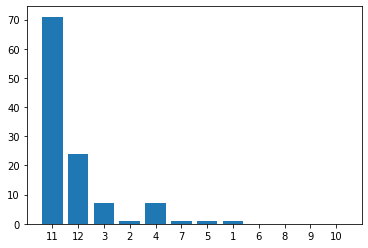

In [7]:
from collections import Counter
dicts = dict(Counter([i for i in norm_df['month'] if i != 'nan']))
for i in range(1, 13):
    if str(i) not in dicts.keys():
        dicts[str(i)] = 0
plt.bar(range(len(dicts)), list(dicts.values()), align='center')
plt.xticks(range(len(dicts)), list(dicts.keys()))

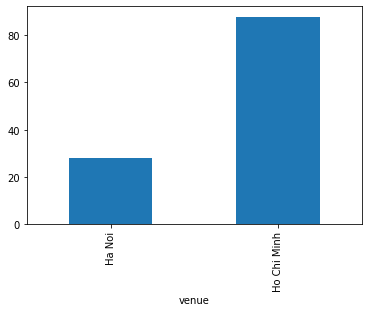

In [8]:
norm_df.groupby("venue").agg({"category": ["count"]}).category['count'].plot.bar()

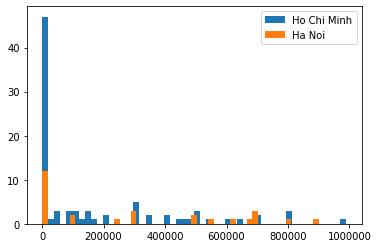

In [9]:
plt.hist(norm_df.groupby("venue")['price'].apply(list)['Ho Chi Minh'], bins=50)
plt.hist(norm_df.groupby("venue")['price'].apply(list)['Ha Noi'], bins=50)
plt.legend(["Ho Chi Minh", "Ha Noi"])

                   price
                   count
category                
Cộng đồng              1
Hội chợ                2
Hội họp                2
Hội thảo              54
Khóa học              14
Ngoài trời             1
Nhạc sống             14
Nightlife              8
Sân khấu               2
Thể thao               8
Vui chơi giải trí      1
Văn hóa nghệ thuật     9


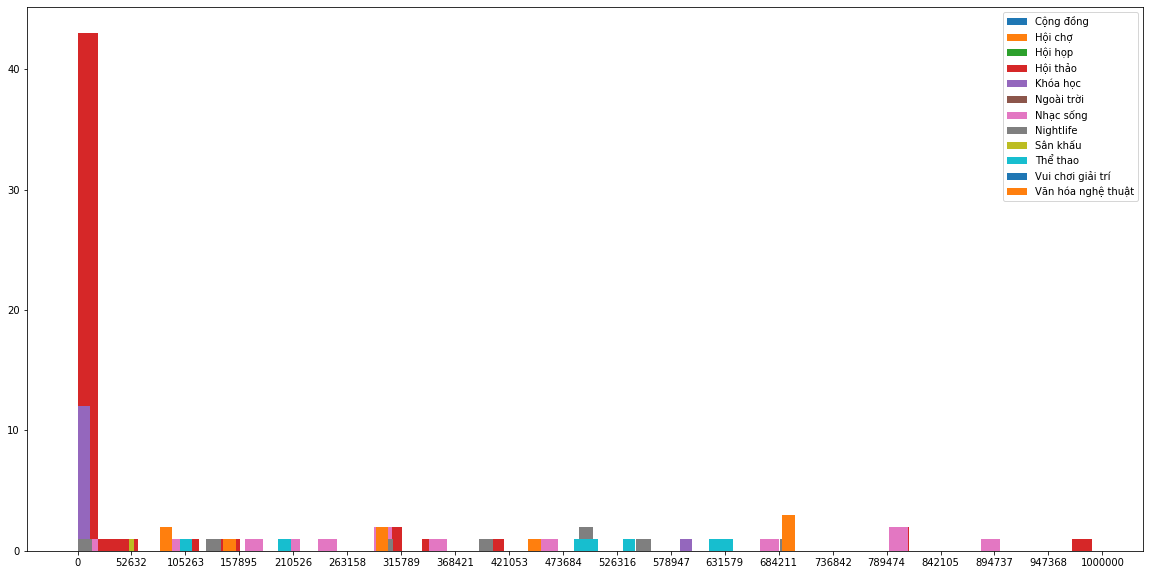

In [10]:
plt.figure(figsize=(20,10))

plt.xticks(np.linspace(0,1000000,20))
for i in norm_df.groupby("category")['price'].apply(list):
    plt.hist(i, bins=50)
plt.legend(norm_df.groupby("category")['price'].apply(list).keys())
print(norm_df.groupby("category").agg({"price": ["count"]}))

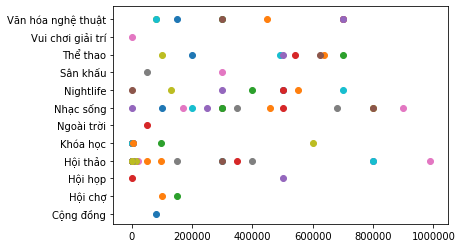

In [13]:
for i, list_of_price in enumerate(norm_df.groupby("category")['price'].apply(list)):
    for p in list_of_price:
        plt.scatter(p, norm_df.groupby("category")['price'].apply(list).keys()[i])


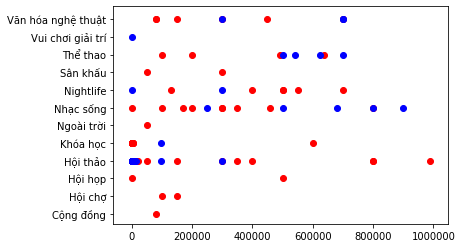

In [26]:
x , y = [], []
venues = {"Ho Chi Minh": 0, "Ha Noi": 1}
for ins in norm_df.groupby("category"):
    for i, p in enumerate(ins[1]['price']):
        cat = ins[1]['category'].tolist()[i]
        venue = ins[1]['venue'].tolist()[i]
        plt.scatter(p, cat, c='red' if venue == 'Ho Chi Minh' else 'blue')
        x.append([venues[venue], list(norm_df.groupby("category")['price'].apply(list).keys()).index(cat)])
        y.append(p)

In [19]:
len(x), len(y)

(116, 116)

In [27]:
x

[[0, 0],
 [0, 1],
 [0, 1],
 [0, 2],
 [0, 2],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [0, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [0, 4],
 [0, 4],
 [0, 4],
 [0, 4],
 [0, 4],
 [0, 4],
 [0, 4],
 [0, 4],
 [0, 4],
 [0, 4],
 [0, 4],
 [0, 4],
 [0, 4],
 [1, 4],
 [0, 5],
 [0, 6],
 [0, 6],
 [0, 6],
 [0, 6],
 [0, 6],
 [0, 6],
 [0, 6],
 [0, 6],
 [0, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [0, 7],
 [0, 7],
 [0, 7],
 [0, 7],
 [0, 7],
 [0, 7],
 [1, 7],
 [1, 7],
 [0, 8],
 [0, 8],
 [0, 9],
 [0, 9],
 [0, 9],
 [0, 9],
 [1, 9],
 [1, 9],
 [1, 9],
 [1, 9],
 [1, 10],
 [0, 11],
 [0, 11],
 [0, 11],
 [0, 1

In [138]:
list(norm_df.groupby("category")['price'].apply(list).keys()).index('Cộng đồng')

0

In [26]:
location = norm_df['location']